In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.constants import speed_of_light as c
from scipy.special import jn
import time
import os
import sys
module_directory = r"C:\Users\Davide\Documents\GitHub\Photonics"
if module_directory not in sys.path:
    sys.path.append(module_directory)
import set_plot_params
set_plot_params.set_plot_params()
mpl.rcParams['ytick.right'] = False

In [36]:
def circular_dielectric_rod_2D_FC(eps1, eps2, a, r, G):
    # eps1: dielectric constant of the circular rod 
    # eps2: dielectric constant of the background 
    volume_fraction = np.pi*r**2/a**2
    if np.linalg.norm(G) != 0:
            xi = 2*volume_fraction*(1/eps1 - 1/eps2)*jn(1, np.linalg.norm(G)*r)/(np.linalg.norm(G)*r)
    else:
        xi = volume_fraction*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def reciprocal_lattice_vectors_2D(d1, d2, theta, N):
    b1 = 2*np.pi/d1*np.array([1, 1/np.tan(theta)])
    b2 = 2*np.pi/(d2*np.sin(theta))*np.array([0, 1])
    G = []
    for h in range(-(N-1), N):
        for k in range(-(N-1), N):
            if abs(h) + abs(k) <= (N-1):
                G.append(h * b1 + k * b2)
    
    return np.array(sorted(G, key=lambda v: np.linalg.norm(v)))

def find_overlapping_intervals(lower1, upper1, lower2, upper2):
    # Store the lower and upper bounds of the overlapping intervals
    overlapping_lower = []
    overlapping_upper = []

    # Loop through each interval in the first set
    for i in range(len(lower1)):
        for j in range(len(lower2)):
            # Find the maximum of the lower bounds
            start = max(lower1[i], lower2[j])
            # Find the minimum of the upper bounds
            end = min(upper1[i], upper2[j])
            # If the start is less than the end, they overlap
            if start < end:
                overlapping_lower.append(start)
                overlapping_upper.append(end)
    
    return overlapping_lower, overlapping_upper

### 2D BANDSTRUCTURE

In [37]:
# set parameters 
dielectric_function = 'circular_rods'
if dielectric_function == 'circular_rods':
    eps1 = 9
    eps2 = 1
    n_ratios = 23
    ratios = np.linspace(0.06, 0.5, n_ratios)

lattice_type = 'square'
if lattice_type == 'oblique':
    d1 = 1e-6
    d2 = d1
    phi = np.pi/4
elif lattice_type == 'rectangular':
    d1 = 1e-6
    d2 = 2e-6
elif lattice_type == 'square':
    d1 = 1e-6
elif lattice_type == 'rhombic':
    d1 = 1e-6
    phi = np.pi/4
elif lattice_type == 'hexagonal':
    d1 = 1e-6

Nk = 100

N = 10
show_bands = 6

eta = 0.003
n_omega = 1000
threshold = 0.01

Execution time of the for loop: 285.835696 seconds


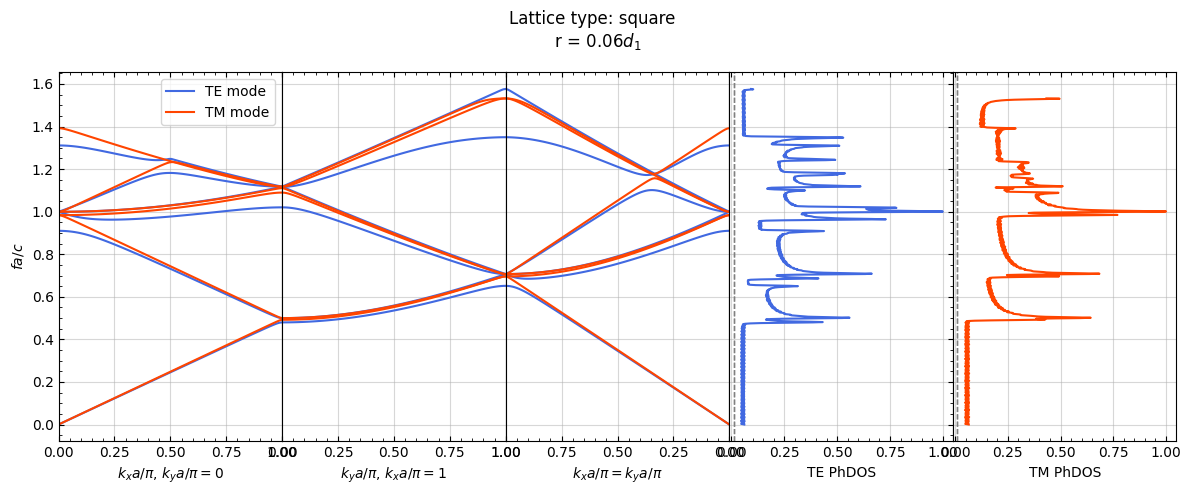

Execution time of the for loop: 284.642863 seconds


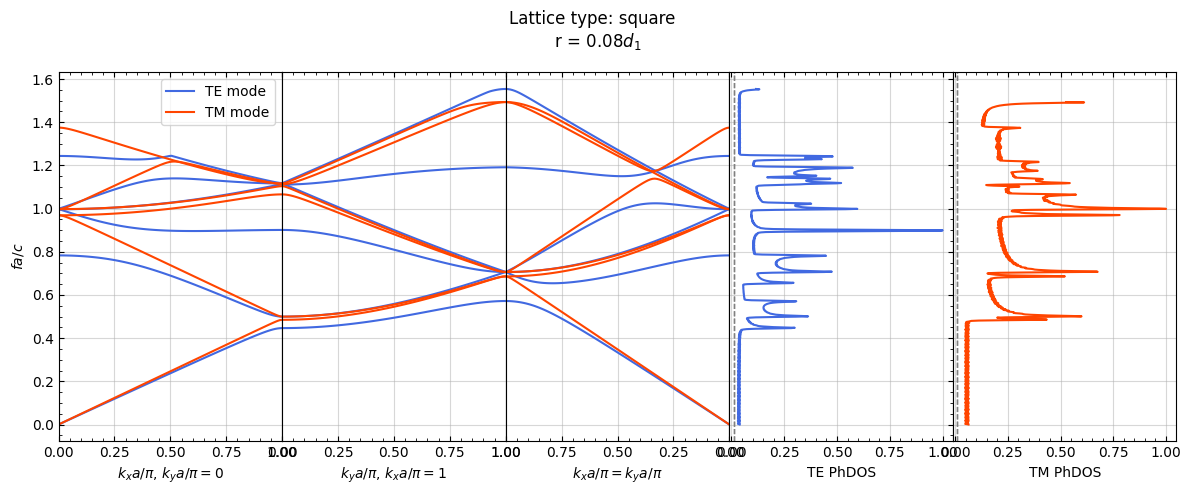

Execution time of the for loop: 286.940046 seconds


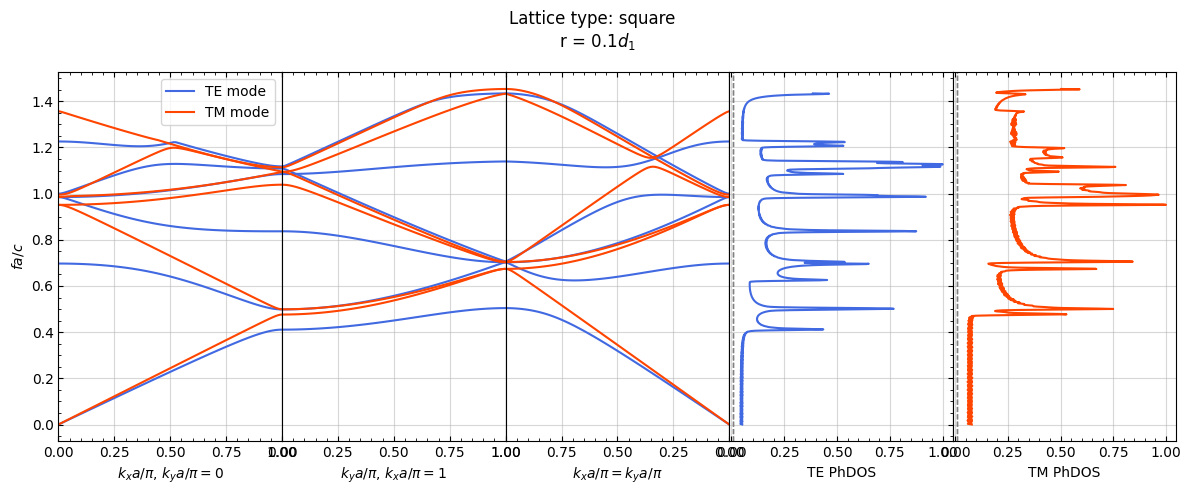

Execution time of the for loop: 285.764692 seconds


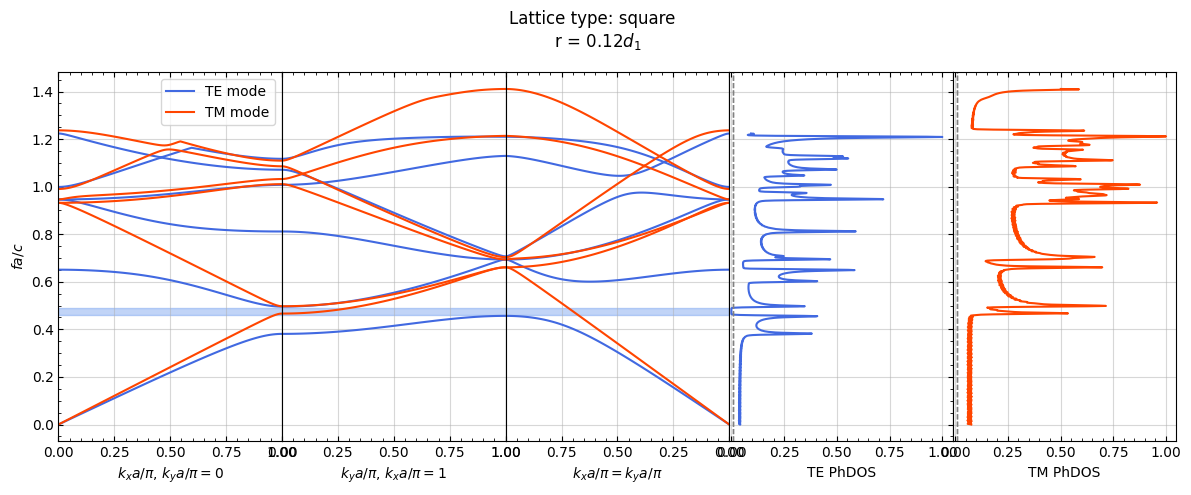

Execution time of the for loop: 285.956465 seconds


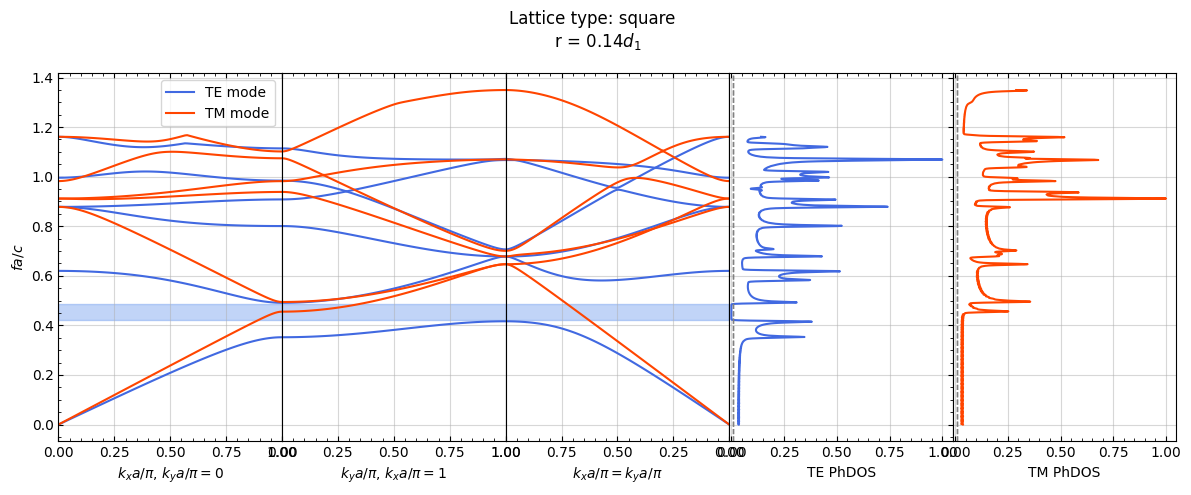

Execution time of the for loop: 289.838866 seconds


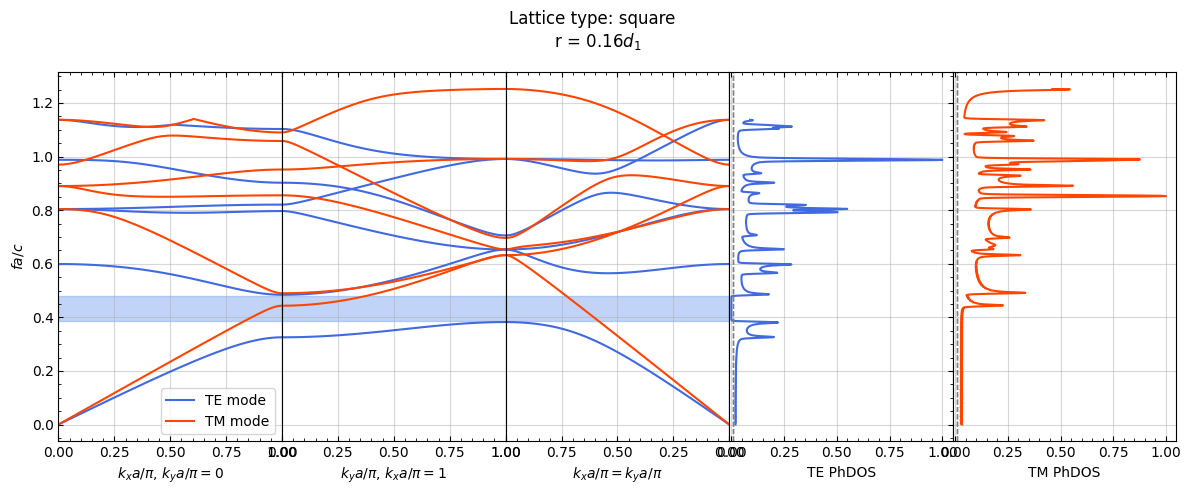

Execution time of the for loop: 292.727998 seconds


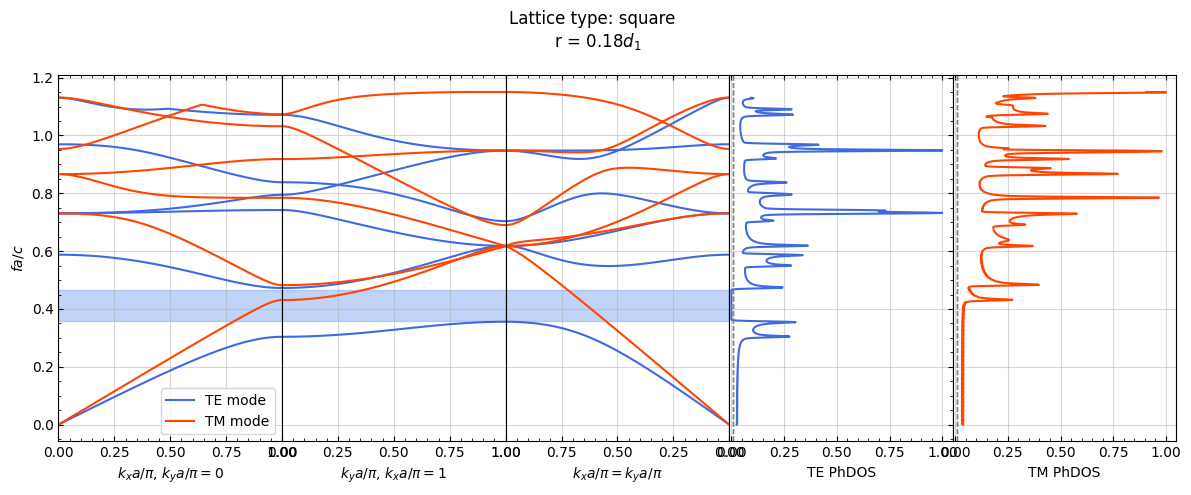

Execution time of the for loop: 291.564108 seconds


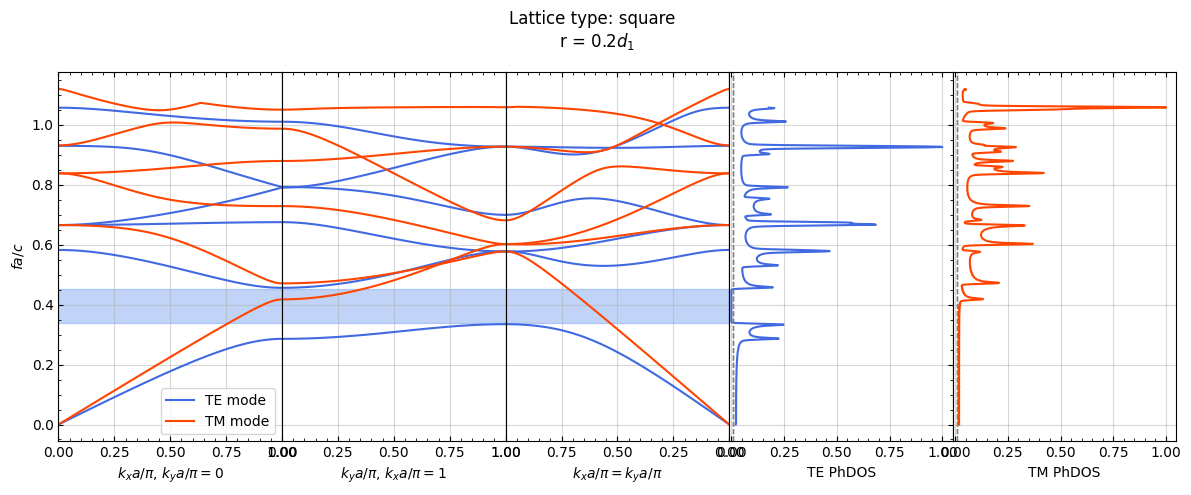

Execution time of the for loop: 293.716233 seconds


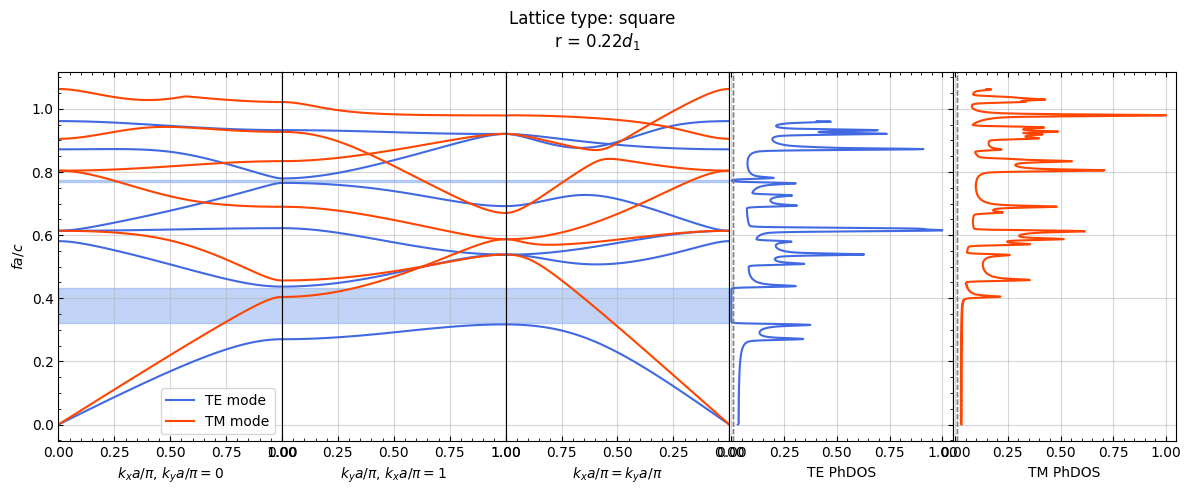

Execution time of the for loop: 293.041690 seconds


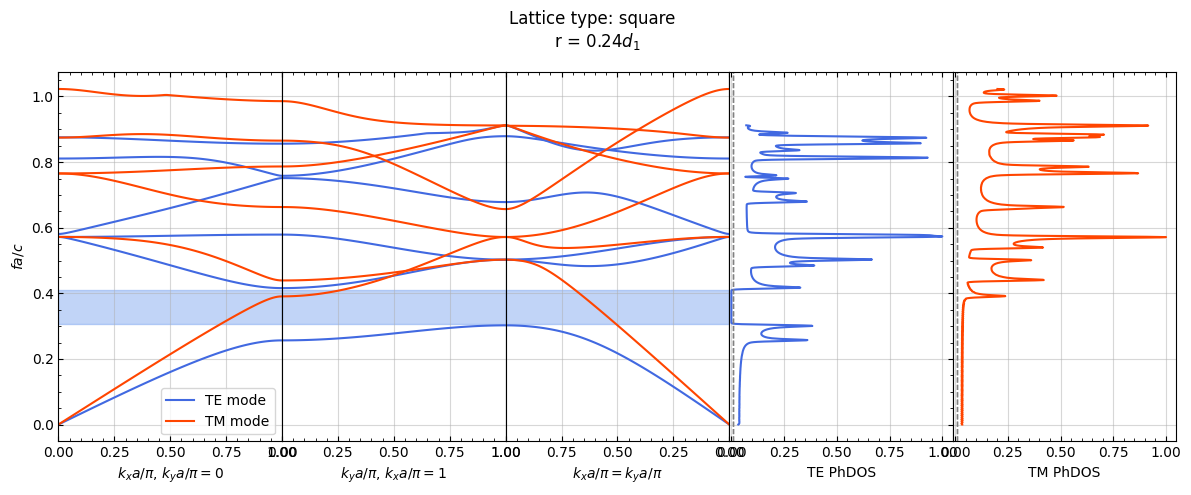

Execution time of the for loop: 295.068761 seconds


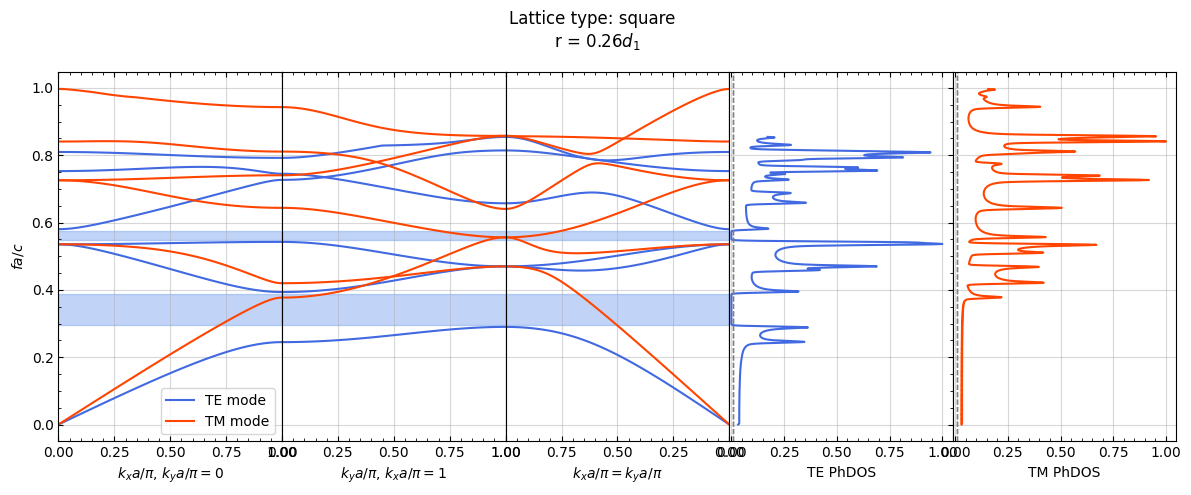

Execution time of the for loop: 294.849341 seconds


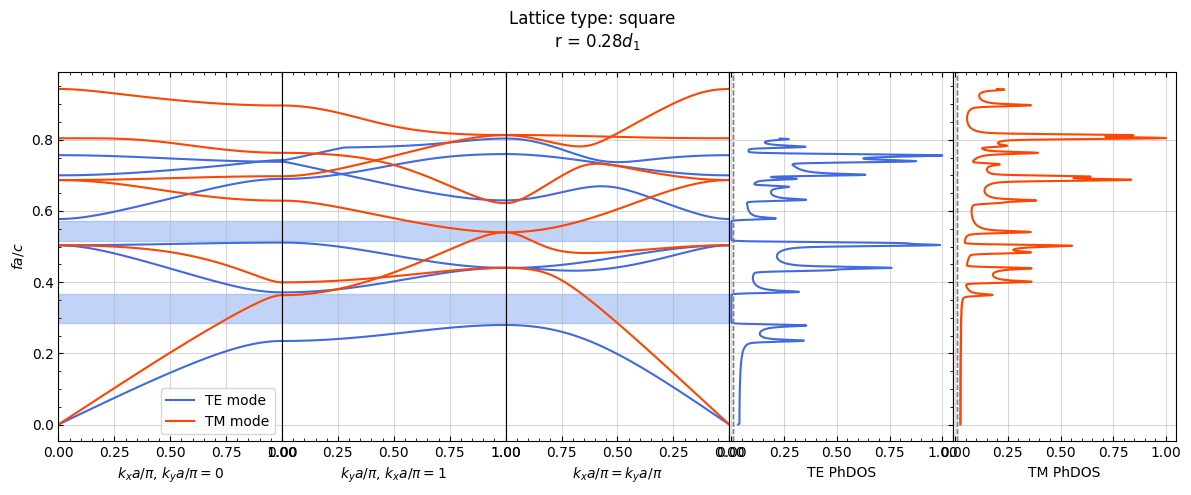

Execution time of the for loop: 292.412113 seconds


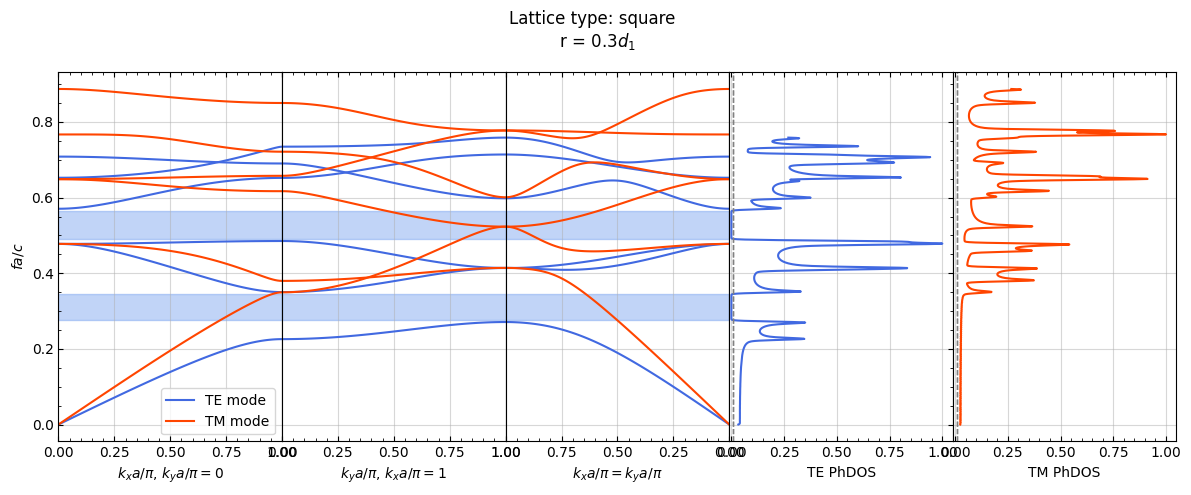

Execution time of the for loop: 286.591334 seconds


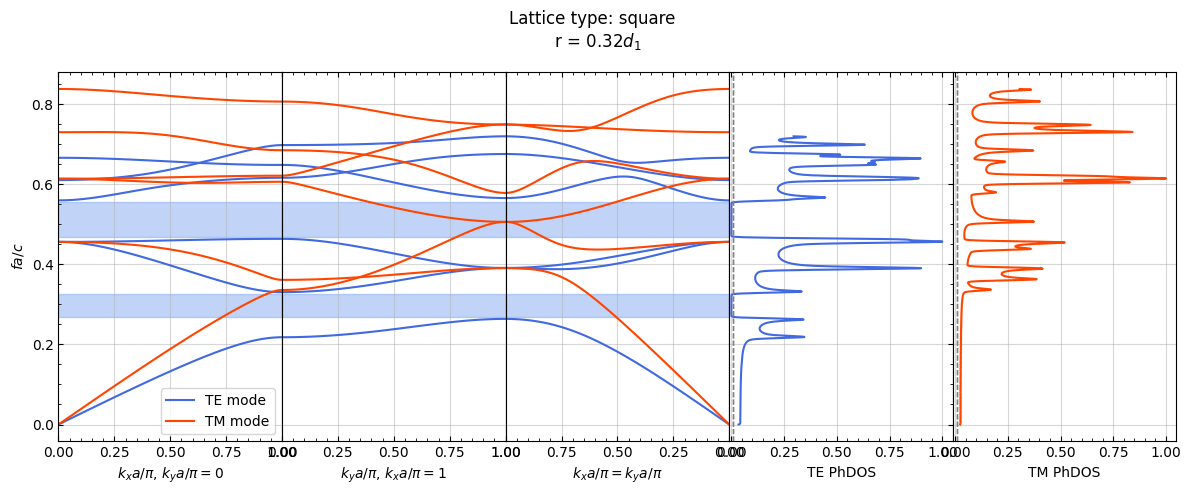

Execution time of the for loop: 282.002960 seconds


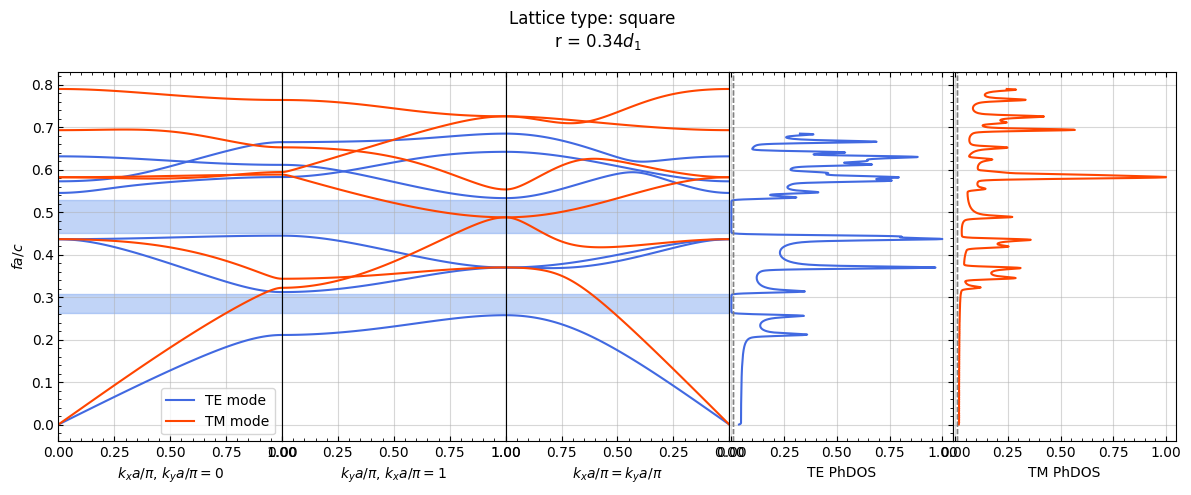

Execution time of the for loop: 282.301808 seconds


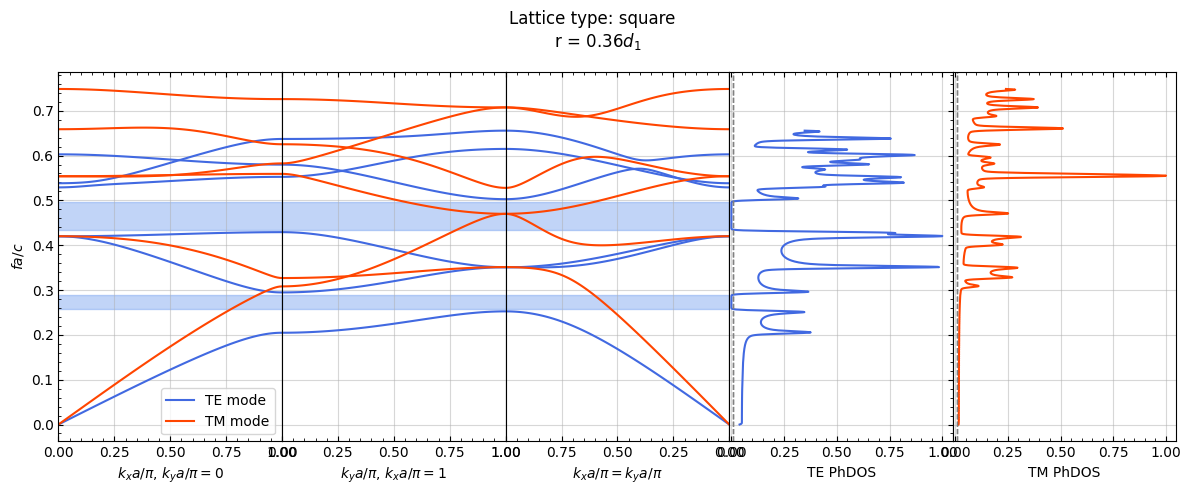

Execution time of the for loop: 277.664572 seconds


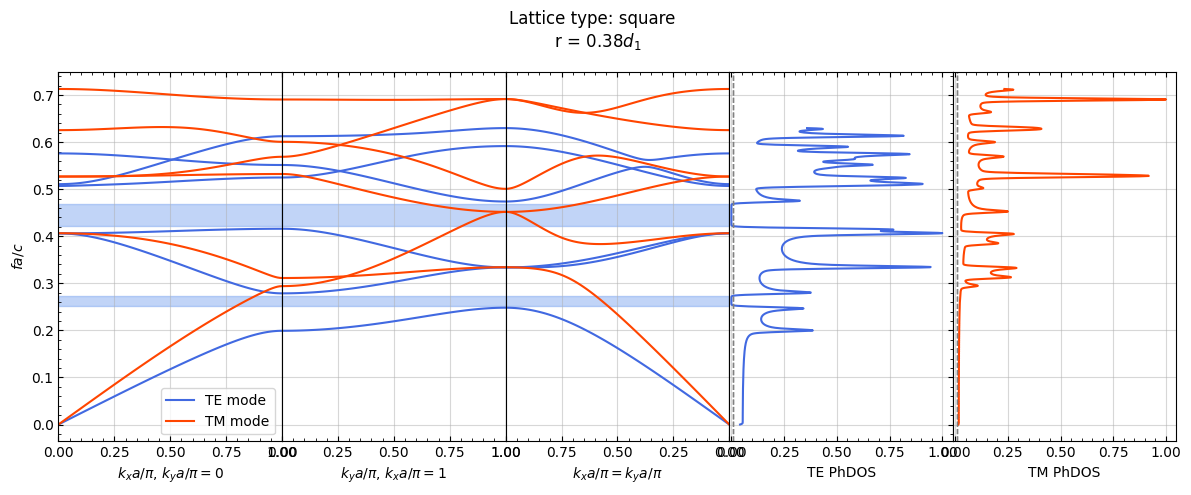

Execution time of the for loop: 280.340438 seconds


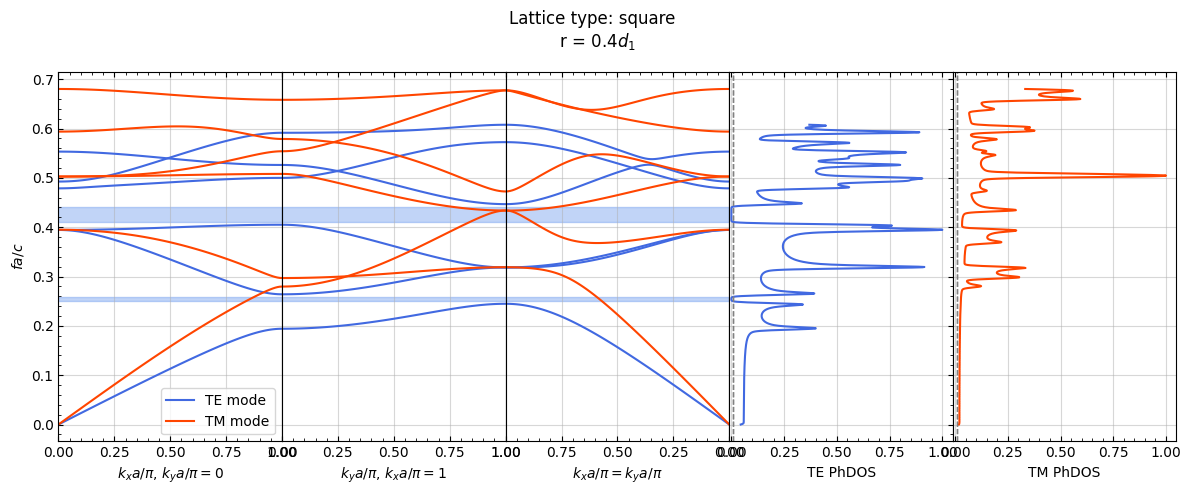

Execution time of the for loop: 273.778285 seconds


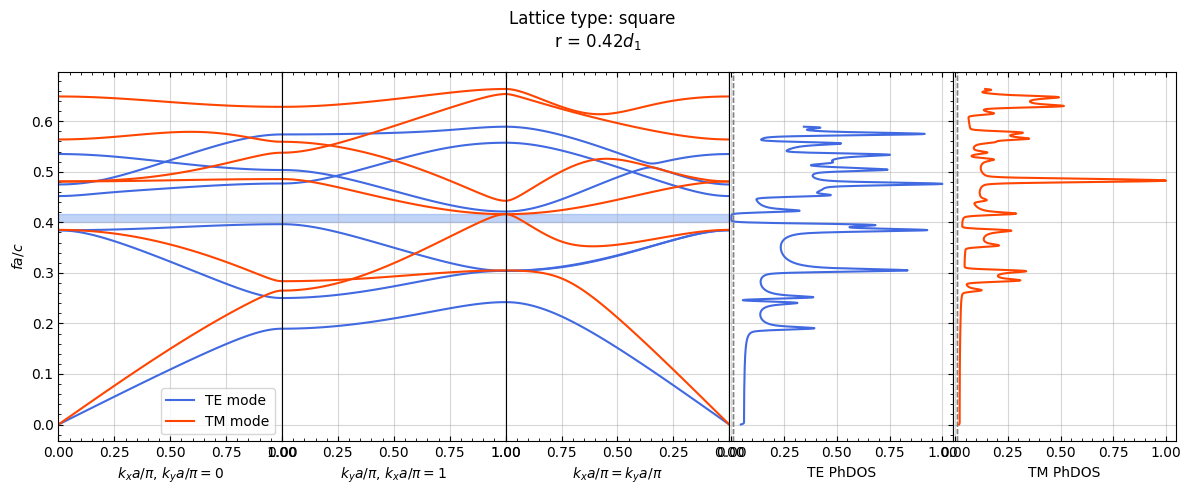

Execution time of the for loop: 274.498466 seconds


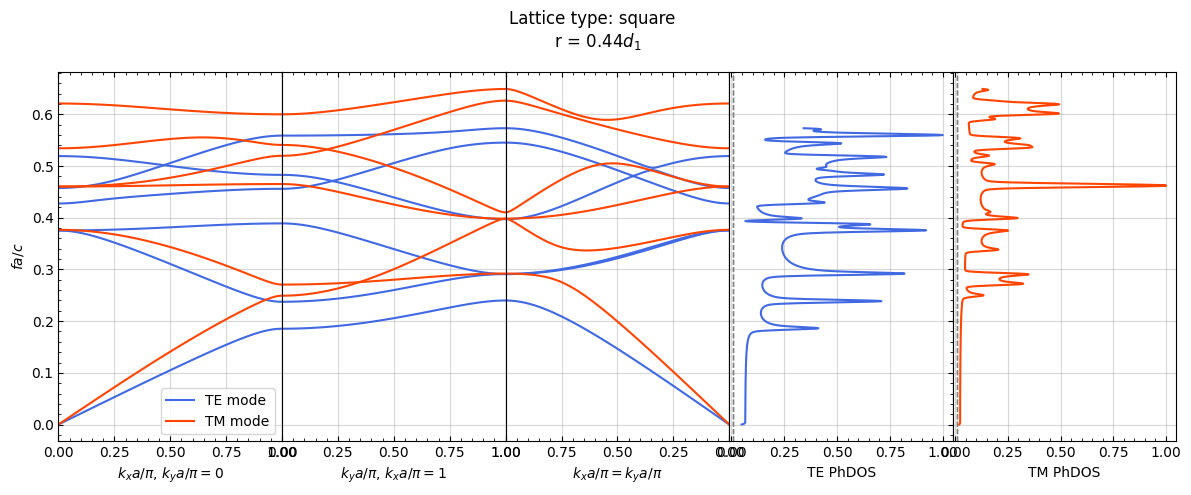

Execution time of the for loop: 275.513707 seconds


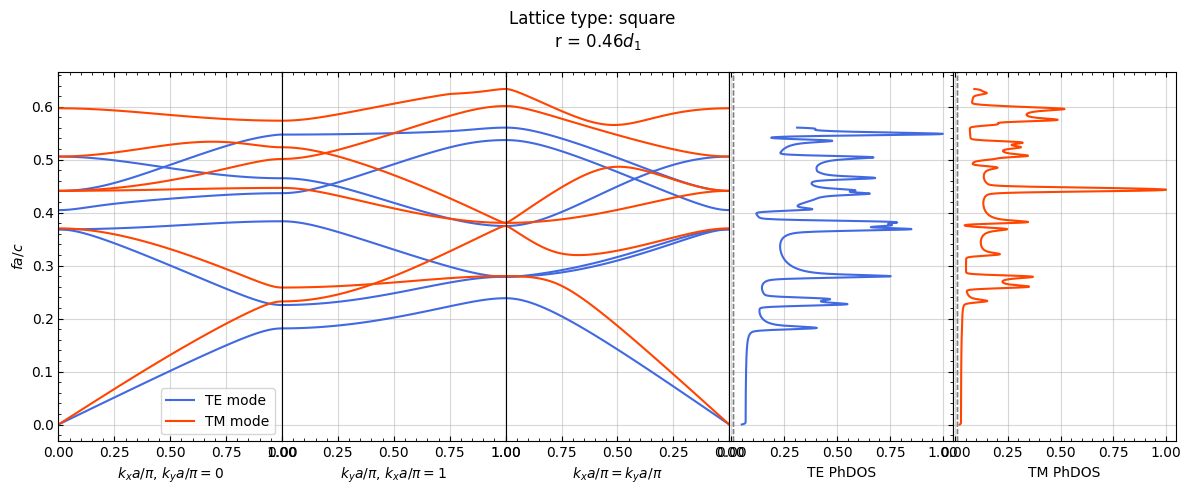

Execution time of the for loop: 274.767086 seconds


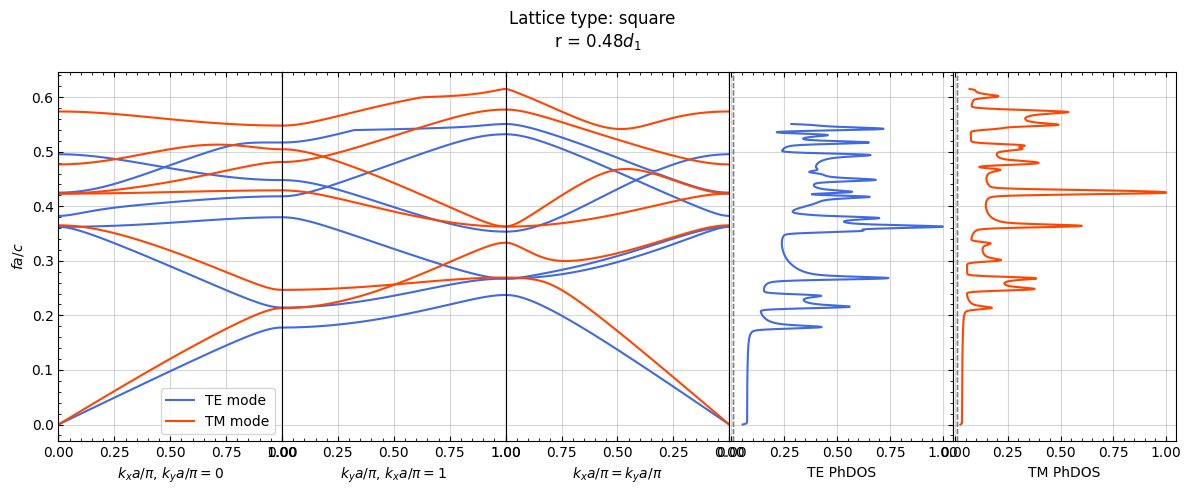

Execution time of the for loop: 270.572760 seconds


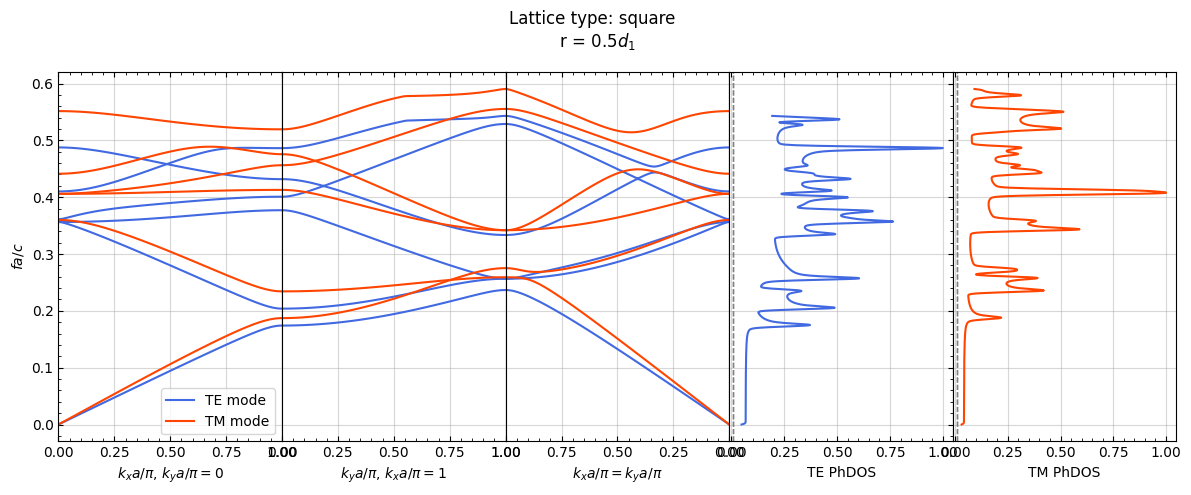

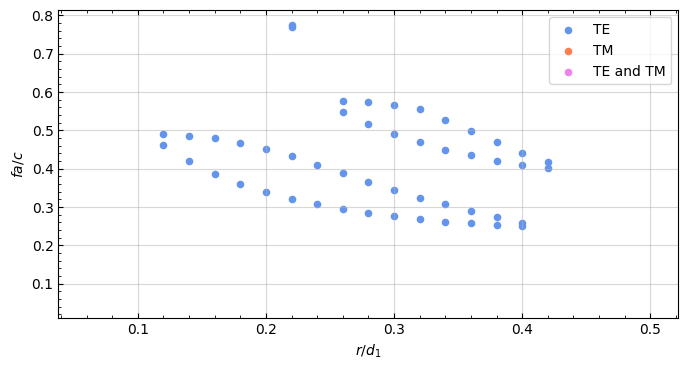

In [38]:
path = os.path.join(dielectric_function, lattice_type)
if not os.path.exists(path):
    os.makedirs(path)

if lattice_type == 'oblique':
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'rectangular':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'square':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
    kxs = np.concatenate([np.linspace(0, np.pi/d1, Nk), np.pi/d1*np.ones(Nk), np.linspace(np.pi/d1, 0, Nk)])
    kys = np.concatenate([np.zeros(Nk), np.linspace(0, np.pi/d1, Nk), np.linspace(np.pi/d1, 0, Nk)])
elif lattice_type == 'rhombic':
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
elif lattice_type == 'hexagonal':
    phi = 2*np.pi/3
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
    kxs = np.concatenate([np.linspace(0, np.pi/d1, Nk), np.pi/d1*np.ones(Nk), np.linspace(np.pi/d1, 0, Nk)])
    kys = np.concatenate([np.zeros(Nk), np.linspace(0, np.pi/(np.sqrt(3)*d1), Nk), np.linspace(np.pi/(np.sqrt(3)*d1), 0, Nk)])

ks = np.stack((kxs, kys), axis=-1)
normalized_ks = ks*d1/(np.pi)
Gs_prime = Gs.copy()
dim = int(1+2*N*(N-1))
edges_TE = np.zeros((n_ratios,2*(dim-1)))
edges_TM = np.zeros((n_ratios,2*(dim-1)))
edges_TE_TM = np.zeros((n_ratios,2*(dim-1)))
show_bands = np.min([dim, show_bands])

colors = ['royalblue', 'orangered']
colors_bandgap = ['cornflowerblue', 'coral', 'violet']
for i1, ratio in enumerate(ratios):
    labels = ['TE mode', 'TM mode']
    r = d1*ratio
    start_time = time.perf_counter()  
    theta_TE = np.zeros((dim, dim), dtype = 'complex')
    theta_TM = np.zeros((dim, dim), dtype = 'complex')
    omegas = np.zeros((Nk*3, 2*dim), dtype = 'complex')
    for i, k in enumerate(ks): 
        for j1, G in enumerate(Gs):
            G_plus_k = G + k
            for j2, G_prime in enumerate(Gs_prime):
                delta_G = G - G_prime 
                if dielectric_function == 'circular_rods':
                    xi = circular_dielectric_rod_2D_FC(eps1, eps2, d1, r, delta_G)
                    theta_TE[j1, j2] = xi*np.linalg.norm(G_prime+k)**2 
                    theta_TM[j1, j2] = xi*np.dot(G_plus_k,G_prime+k)  
        eigenvalues, eigenvectors = np.linalg.eig(theta_TE)
        sorted_indices = np.argsort(eigenvalues)
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        omegas[i][:dim] = sorted_eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(theta_TM)
        sorted_indices = np.argsort(eigenvalues)
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        omegas[i][dim:] = sorted_eigenvalues

    omegas = np.sqrt(np.real(omegas))*c
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Execution time of the for loop: {elapsed_time:.6f} seconds") 

    fig = plt.figure(figsize = (12,5))
    gs = GridSpec(1, 5, width_ratios=[1, np.max(normalized_ks[Nk:2*Nk,1])/np.max(normalized_ks[:Nk,0]), 1, 1, 1])
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1], sharey=ax0)
    ax2 = fig.add_subplot(gs[2], sharey=ax0)
    ax3 = fig.add_subplot(gs[3], sharey=ax0)
    ax4 = fig.add_subplot(gs[4], sharey=ax0)
        
    fig.suptitle(f"Lattice type: {lattice_type} \n r = ${round(ratio,2)}d_1$")
    
    for T_index in range(2):
         
        normalized_omegas = omegas[:, T_index*dim:T_index*dim + show_bands]*d1/(2*np.pi*c)
        omega_min = np.min(normalized_omegas)
        omega_max = np.max(normalized_omegas)
        omega_range = np.linspace(omega_min, omega_max, n_omega)
        D_omega = np.zeros_like(omega_range)
        for omega_k_modes in normalized_omegas.T:
            for omega_k_val in omega_k_modes:
                D_omega += 1/(eta*np.sqrt(np.pi))*np.exp(-(omega_range - omega_k_val)**2/eta**2)
        D_omega = D_omega/np.max(D_omega)

        lower_edges = []
        upper_edges = []
        for idx in range(0,D_omega.size-1):
            if (D_omega[idx]>= threshold) and (D_omega[idx+1] <= threshold) :
                lower_edges.append(omega_range[idx])
            if (D_omega[idx] < threshold) and (D_omega[idx+1] >= threshold) :
                upper_edges.append(omega_range[idx])

        if T_index == 0:
             edges_TE[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))
             ax3.plot(D_omega, omega_range, color = colors[T_index])
             ax3.set_xlabel("TE PhDOS")
        else:
             edges_TM[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))
             ax4.plot(D_omega, omega_range, color = colors[T_index])
             ax4.set_xlabel("TM PhDOS")
 
        ax0.plot(normalized_ks[:Nk,0], normalized_omegas[:Nk], color = colors[T_index], label = labels[T_index])
        ax1.plot(normalized_ks[Nk:2*Nk,1], normalized_omegas[Nk:2*Nk], color = colors[T_index])
        ax2.plot(normalized_ks[2*Nk:,0], normalized_omegas[2*Nk:], color = colors[T_index])  
        ax3.axvline(threshold, linestyle = "--", linewidth = 1, color = "grey")
        ax4.axvline(threshold, linestyle = "--", linewidth = 1, color = "grey")

        for i in range(len(lower_edges)):
            ax0.axhspan(lower_edges[i], upper_edges[i], alpha=0.4, color=colors_bandgap[T_index])
            ax1.axhspan(lower_edges[i], upper_edges[i], alpha=0.4, color=colors_bandgap[T_index])
            ax2.axhspan(lower_edges[i], upper_edges[i], alpha=0.4, color=colors_bandgap[T_index])
            #ax3.axhspan(lower_edges[i], upper_edges[i], alpha=0.4, color=colors_bandgap[T_index]) 
            #ax4.axhspan(lower_edges[i], upper_edges[i], alpha=0.4, color=colors_bandgap[T_index]) 
        
        overlapping_lower, overlapping_upper = find_overlapping_intervals(edges_TE[i1][::2], edges_TE[i1][1::2], edges_TM[i1][::2], edges_TM[i1][1::2])
        for i in range(len(overlapping_lower)):
            ax0.axhspan(overlapping_lower[i], overlapping_upper[i], alpha=0.4, color=colors_bandgap[2])
            ax1.axhspan(overlapping_lower[i], overlapping_upper[i], alpha=0.4, color=colors_bandgap[2])
            ax2.axhspan(overlapping_lower[i], overlapping_upper[i], alpha=0.4, color=colors_bandgap[2])
            #ax3.axhspan(overlapping_lower[i], overlapping_upper[i], alpha=0.4, color=colors_bandgap[2])

        edges_TE_TM[i1][:len(overlapping_lower) + len(overlapping_upper)] = np.sort(np.concatenate([overlapping_lower, overlapping_upper]))
            
    ax0.set_ylabel("$fa/c$")
    ax0.set_xlabel(r"$k_xa/\pi$, $k_ya/\pi = 0$")
    ax1.set_xlabel(r"$k_ya/\pi$, $k_xa/\pi = 1$")
    ax2.set_xlabel(r"$k_xa/\pi = k_ya/\pi$ ")
    
    ax2.set_xlim(ax2.get_xlim()[::-1])

    ax0.set_xlim(np.min(normalized_ks[:Nk,0]), np.max(normalized_ks[:Nk,0]))
    ax1.set_xlim(np.min(normalized_ks[Nk:2*Nk,1]),np.max(normalized_ks[Nk:2*Nk,1]))
    ax2.set_xlim(np.max(normalized_ks[2*Nk:,0]),np.min(normalized_ks[2*Nk:,0]))
    ax3.set_xlim(-0.01,None)
    ax4.set_xlim(-0.01,None)

    ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    ax3.yaxis.tick_right() 

    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    handles, labels = ax0.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax0.legend(by_label.values(), by_label.keys())
    plt.savefig(os.path.join(path, f"bandstructure_a{d1*1e6}um_eps_rod{eps1}_eps_back{eps2}_ratio{round(ratio,2)}.png"), dpi = 150)
    plt.show()

fig, ax = plt.subplots(ncols=1, figsize = (8,4), sharey=True)
for i in range(2*(dim-1)):
    ax.scatter(ratios, edges_TE.T[i], s = 20, color = colors_bandgap[0], label = 'TE')
    ax.scatter(ratios, edges_TM.T[i], s = 20, color = colors_bandgap[1], label = 'TM')
    ax.scatter(ratios, edges_TE_TM.T[i], s = 20, color = colors_bandgap[2], label = 'TE and TM')

ax.set_ylim(0.01, None)
ax.set_xlabel("$r/d_1$")
ax.set_ylabel("$fa/c$")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.savefig(os.path.join(path, f"bandgap_map_a{d1*1e6}um_eps_rod{eps1}_eps_back{eps2}.png"), dpi = 150)
plt.show()

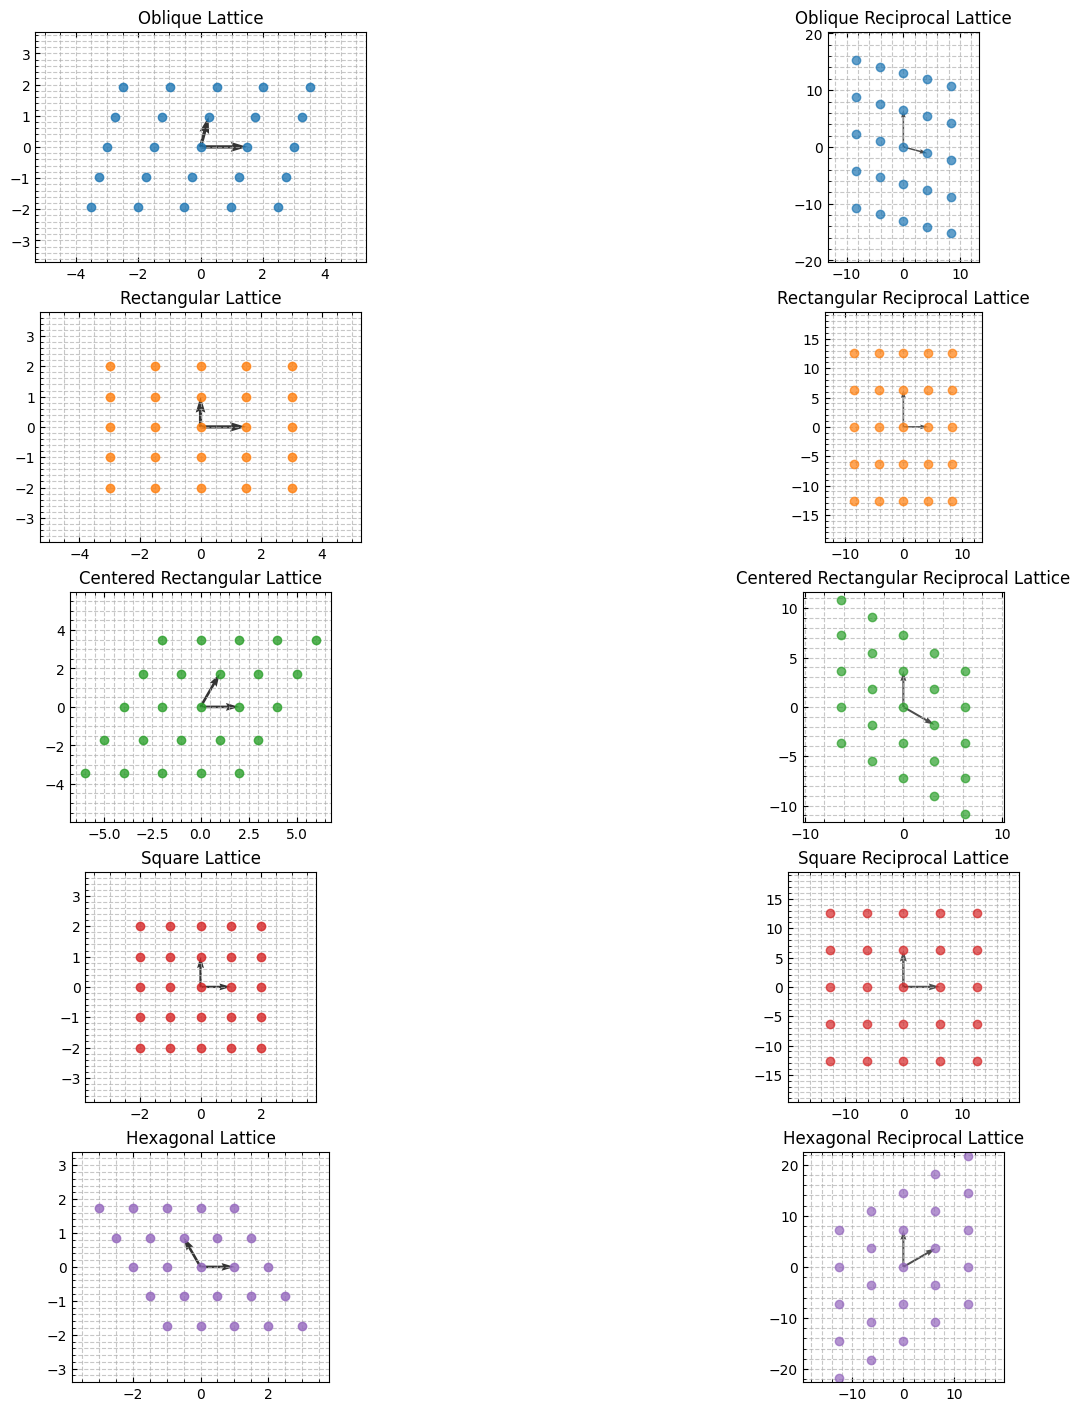

: 

In [39]:
def create_oblique_lattice(a, b, theta):
    a1 = np.array([a, 0])
    a2 = np.array([b * np.cos(np.radians(theta)), b * np.sin(np.radians(theta))])
    return a1, a2

def plot_lattice(a1, a2, title, ax, lattice_color='b', lattice_alpha=0.8, arrow_color='k'):
    # Draw the direct lattice points
    for i in range(-2, 3):
        for j in range(-2, 3):
            point = i * a1 + j * a2
            ax.plot(point[0], point[1], 'o', color=lattice_color, alpha=lattice_alpha)
    # Draw the lattice vectors
    ax.quiver(0, 0, a1[0], a1[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.quiver(0, 0, a2[0], a2[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

def reciprocal_lattice(a1, a2):
    area = np.cross(a1, a2)
    b1 = 2 * np.pi * np.array([a2[1], -a2[0]]) / area
    b2 = 2 * np.pi * np.array([-a1[1], a1[0]]) / area
    return b1, b2

def set_dynamic_limits(ax, a1, a2):
    # Compute limits based on lattice vectors
    x_max = max(abs(a1[0]), abs(a2[0])) * 3 + 0.8
    y_max = max(abs(a1[1]), abs(a2[1])) * 3 + 0.8
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)

# Define lattice vectors for different types of lattices
lattices = {
    "Oblique": (1.5, 1.0, 75),
    "Rectangular": (1.5, 1.0, 90),
    "Centered Rectangular": (2.0, 2.0, 60),
    "Square": (1.0, 1.0, 90),
    "Hexagonal": (1.0, 1.0, 120)
}

fig, axs = plt.subplots(len(lattices), 2, figsize=(14, 14), constrained_layout=True)

# Use different colors for each lattice type
colors = plt.cm.tab10.colors[:len(lattices)]

for i, (name, (a, b, theta)) in enumerate(lattices.items()):
    a1, a2 = create_oblique_lattice(a, b, theta)
    b1, b2 = reciprocal_lattice(a1, a2)
    
    # Plot real lattice (lighter color)
    plot_lattice(a1, a2, f"{name} Lattice", axs[i, 0], lattice_color=colors[i], arrow_color='k')
    set_dynamic_limits(axs[i, 0], a1, a2)
    
    # Plot reciprocal lattice (darker color)
    plot_lattice(b1, b2, f"{name} Reciprocal Lattice", axs[i, 1], lattice_color=colors[i], lattice_alpha=0.7, arrow_color='k')
    set_dynamic_limits(axs[i, 1], b1, b2)

plt.show()